# Functional basis
Functional bases are useful for studying weighted addition because the output signals are known to be some combination of the inputs. The basis of original inputs is finite. As long as the basis signals are linearly separable, the multiple weights imparted by the weight bank can be decomposed from just one measurement. Furthermore, this is all very low noise because a weight is determined by an average over an entire oscilloscope window. Things that are **not** part of the basis, such as noise power and distortion, can be pulled out as remainders and studied.

In this notebook, we make some signals and noise and some mixtures of those signals. We make a full basis of all of them, and we make a basis that is just the signals

In [1]:
# Reload modules every time code is called. Set autoreload 0 to disable
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import lightlab.util.data as dUtil
from lightlab.util.data import FunctionalBasis, Waveform, FunctionBundle

## Initial signals

In [2]:
# Make some simple signals
t = np.linspace(0,1,300)
# noi1 = Waveform(t, .05 * np.random.randn(len(t))) # pseudo-noise
noi1 = Waveform(t, .1 * np.sin(2*np.pi*50*t))
sou1 = Waveform(t, np.sin(2*np.pi*2*t) * np.sin(2*np.pi*10*t))
sou2 = Waveform(t, np.cos(2*np.pi*5*t) + 0*np.sign(t%.2 - .1)) + noi1
# Mixtures
rec1 = .9 * sou1 - .6 * sou2
rec2 = .1 * sou1 + .8 * sou2
# Other signal
rec3 = Waveform(t, .4 * np.sin(25*t)) - .5*noi1 

# High sampling rate signals
# t = np.linspace(0,1, 10000)
# n1 = Waveform(t, .05 * np.random.randn(len(t))) # pseudo-noise
# s3 = Waveform(t, .05 * np.random.randn(len(t))) # pseudo-noise
# carrierFreq = 8
# modFreq = 2
# s1 = Waveform(t, np.sin(2*np.pi*carrierFreq*t) * (1 + np.cos(2*np.pi*modFreq*t)) / 2)
# s2 = Waveform(t, np.sin(2*np.pi*carrierFreq*t))

## Create signal basis

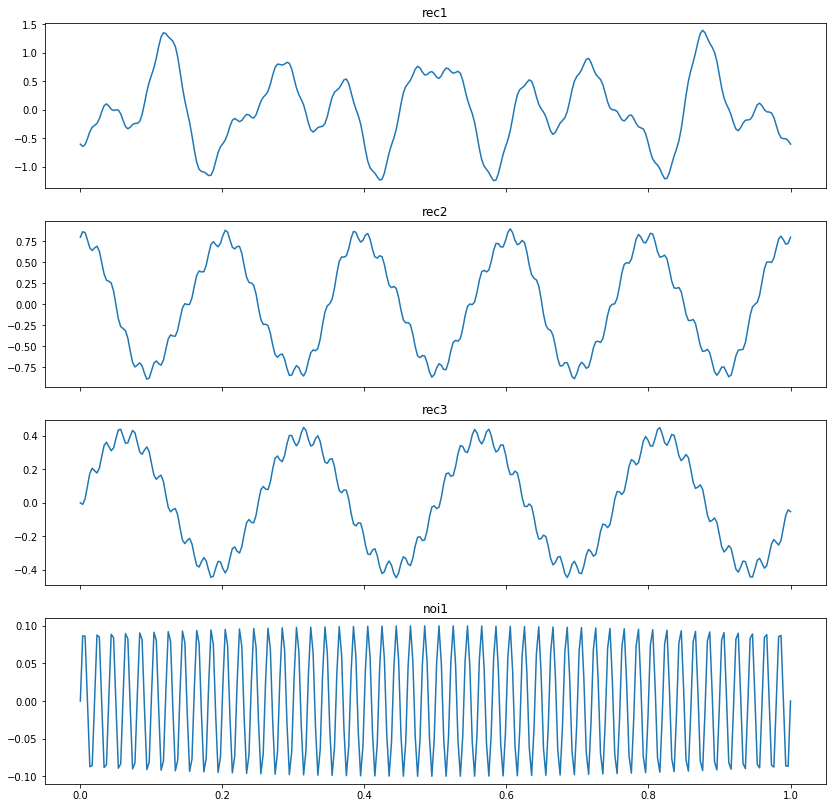

In [3]:
# bTest only contains s1 and s2, while bFull has everything
bTest = FunctionalBasis([rec1,rec2])
bFull = FunctionalBasis([rec1,rec2,rec3,noi1])
for i,ax in enumerate(bFull.multiAxisPlot()):
    ax.set_title(['rec1', 'rec2', 'rec3', 'noi1'][i])

In [4]:
# makes a trial function based on weighted addition of the full basis
# decompose limited basis and look at remainder
# then decompose the remainder in the full basis
def trial(weights):
    tfun = bFull.weightedAddition(weights)
#     print(tfun.ordi.shape)
    tfun.simplePlot()
    dec = bTest.decompose(tfun)
    bTest.weightedAddition(dec).simplePlot()
    for i in range(len(dec)):
        print('Weight {}: actual {:2.3f}, test decomposed {:2.3f}'.format(i, weights[i], dec[i]))
        
    rfun = bTest.remainder(tfun)
#     rfun.simplePlot()
    
    fullDec = bFull.decompose(rfun)
    print()
    for i in range(len(fullDec)):
        print('Remainder {}: {:2.3f}'.format(i, fullDec[i]))

Weight 0: actual -0.700, test decomposed -0.703
Weight 1: actual 0.500, test decomposed 0.524

Remainder 0: 0.003
Remainder 1: -0.024
Remainder 2: -2.000
Remainder 3: 1.000


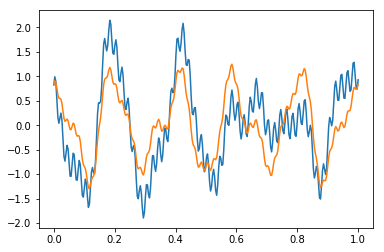

In [5]:
# try it yourself by entering weights for rec1,2,3, and noi1
trial(np.array([-.7,.5,-2,1]))

## Component analysis
Methods for computing the principal components and independent components of the full basis. They use the SVD methods that are typical of digital processors.

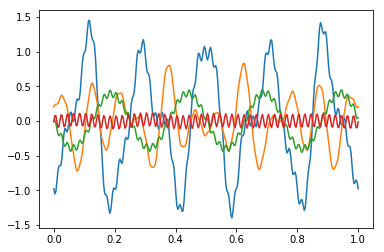

In [6]:
bFull.componentAnalysis(pcaIca=True).simplePlot()

And here are the independent components

/Users/atait/Dropbox/Documents/gitProjects/experiment-code/lightlab/venv/lib/python3.6/site-packages/scipy/linalg/basic.py:1321: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  x, resids, rank, s = lstsq(a, b, cond=cond, check_finite=False)


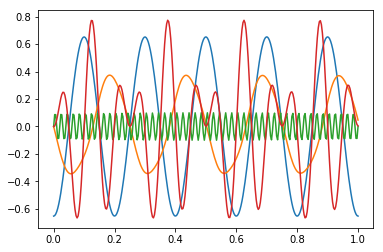

In [7]:
bFull.componentAnalysis(pcaIca=False).simplePlot()

## FunctionBundle feedthroughs
Methods for `MeasuredFunction` signal processing can be called directly on bundles of them.

This means that the process is applied to each member function, which are then rebundled and returned 

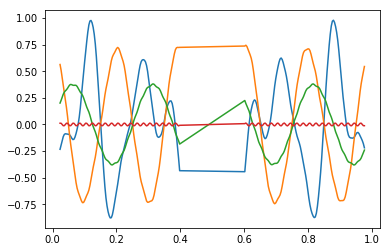

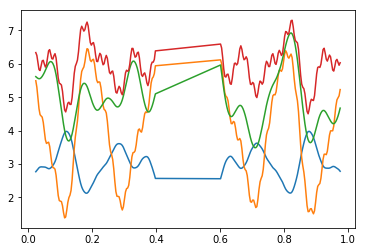

In [13]:
repack = bFull.lowPass(.05).deleteSegment([.4, .6])
repack.simplePlot()
assert type(bFull) is type(repack)
assert bFull.lowPass.__doc__ == Waveform.lowPass.__doc__

# Try out binary math
repack *= 2 # scalar
repack = repack * [1, 2, 3, 4] # vector
repack = repack - bFull[0] # 1D MeasuredFunction
repack = repack + bFull # other FunctionBundle
plt.figure()
repack.simplePlot()